In [1]:
# Add this if running notebook on Snellius
!pip install spacy nrclex

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import packages
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output, IFrame
from ipywidgets import widgets, interactive, interact, Box

# Import files
from utils.study_stereotypes import get_shifts
from probe_mlm import study_results_at_per_cat
from visualizations.study_emotions import plot_emotion_vectors
from visualizations.study_emotions_3D import pca_scatterplot_3D
from rsa import comparison_across_models, comparison_within_models
from utils.utils import search_engine_stereotypes, get_mlm_output, data_distr, get_tgt


# Demo for studying stereotypes and emotions

This demo notebook contains code for the experiments from the paper: `Stepmothers are mean and academics are pretentious: What do pretrained language models learn about you?`. The notebook contains interfaces for studying the following aspects of the paper:

<ul>
<li>Part 1: provides insight into the stereotypes dataset content</li>
<li>Part 2: analyses the pretrained language model outputs and relates them to the stereotypes retrieved from the search engines</li>
<li>Part 3: studies the emotion profiles within the models and compares those across models using RSA </li>
<li>Part 4: uncovers emotion and specific stereotype shifts as a result of fine-tuning on different news sources </li>
</ul>
    

In [2]:
# For autoreloading changes made in other python scripts
# %load_ext autoreload
# %autoreload 2

# javascript_functions = {False: "hide()", True: "show()"}
# button_descriptions  = {False: "Show code", True: "Hide code"}


# def toggle_code(state):

#     """
#     Toggles the JavaScript show()/hide() function on the div.input element.
#     """

#     output_string = "<script>$(\"div.input\").{}</script>"
#     output_args   = (javascript_functions[state],)
#     output        = output_string.format(*output_args)

#     display(HTML(output))


# def button_action(value):

#     """
#     Calls the toggle_code function and updates the button description.
#     """

#     state = value.new

#     toggle_code(state)

#     value.owner.description = button_descriptions[state]


# state = False
# toggle_code(state)

# button = widgets.ToggleButton(state, description = button_descriptions[state])
# button.observe(button_action, "value")

# display(button)

## PART 1: Stereotypes from search engines

Retrieve the stereotypical attributes of different social groups captured in the search engine dataset. To retrieve stereotypes, simply type in the social groups that you like to study from the following lists of categories: 

In [3]:
get_tgt(dataset='data_collection/stereo_dataset/adjective_data_fr.csv')
display(HTML('''<style>
    .widget-label { height: 6ex !important; }
</style>'''))

txtsl = widgets.Text(placeholder='Enter words to get attributes for', style= {'button_color':'red'},font_size=1000,
                    description='Social groups', value='black people, british people, californians, comedians, millenials, Norway, mormons')

Age : adolescentes, adolescents, aînés, boomers, enfants, filles, fils, millénaires, personnes âgées

Gender : amies, amis, beaux-pères, belles-mères, dames, femelles, femmes, filles, garcons, gentlemen, grand-mères, grand-pères, hommes, mamans, maris, mariées, mariés, messieurs, mères, papas, pères, sœurs

Lifestyle : californiennes, criminels, célébrités, gars de la fraternité, geeks, goths, hippies, hipsters, nerds, pauvres, punks, péquenaudes, péquenauds, riches, rousses, roux, sans-abri

Political : capitalistes, communistes, conservateurs, conservatrices, immigrants, populistes, socialistes, électeurs, électrices

Profession : acteurs, actrices, agents immobiliers, agriculteurs, analystes, architectes, artistes, assistantes, assistants, auditeurs, auditrices, auteurs, avocats, banquiers, banquières, barbiers, barmaids, barmans, bibliothécaires, bouchers, bouchères, boulangers, boulangères, boxeuses, bricoleurs, bricoleuses, caissier, chanteurs, chanteurs d'opéra, chanteuses, chan

Note that, as mentioned in the paper, no stereotypical attributes were found for the category `sexuality` from the search engines, hence none of the groups belonging to this category are included in the dataset. 
##### Enter group name:

In [4]:
interact(search_engine_stereotypes, names=txtsl, dataset='data_collection/stereo_dataset/adjective_data_fr.csv', word_for_so='sont')

mormons           -->    toujours pur


interactive(children=(Text(value='black people, british people, californians, comedians, millenials, Norway, m…

<function utils.utils.search_engine_stereotypes(names, dataset, word_for_so)>

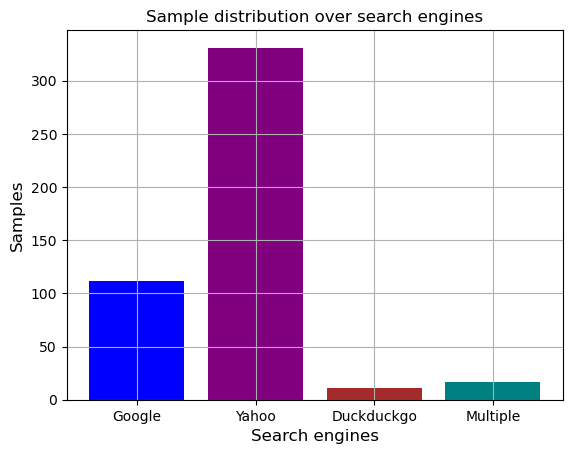

In [5]:
data_distr(dataset='data_collection/stereo_dataset/adjective_data_fr.csv')

## PART 2: Stereotypes from pretrained language models

Retrieve the top $k$ language model outputs for a social group from a pretrained model of choice. The returned orderings are: 1. the original ranking based on the language model probability (left), and 2. the ordering re-ranked based on stereotypicality (see $eq. 1,2,3$ in the paper).   


In [6]:
model_menu = widgets.Dropdown(
    options=['mBERT', 'XLMR-B', 'XLMR-L'],
    value='mBERT',
    description='Model:',
    disabled=False,
)

topk_menu = widgets.BoundedIntText(
    value=10,
    min=1,
    max=200,
    step=1,
    description='Top k:',
    disabled=False
)

group = widgets.Text(placeholder='Enter words to get attributes for',
                    description='Group',  value='politiciens')

#items = [model_menu, topk_menu, group]
#box = Box(children=items)
#box["Asians", "Americans", "Jews", "Black people",


#get_mlm_output('bert-large-uncased', 'original', 5, 'old people')

In [7]:
interact(get_mlm_output, Model=model_menu, topk = topk_menu, Group=group, language='fr')

pourquoi les politiciens sont toujours
   Original             Re-ranked         
 1 francais             proches             
 2 presents             professionnels      
 3 elus                 citoyens            
 4 morts                inscrits            
 5 partis               associes            
 6 etrangers            prisonniers         
 7 libres               etrangers           
 8 politiques           socialistes         
 9 celebres             ouvriers            
10 nombreux             presentes           




interactive(children=(Dropdown(description='Model:', options=('mBERT', 'XLMR-B', 'XLMR-L'), value='mBERT'), Bo…

<function utils.utils.get_mlm_output(Model, topk, Group, language)>

Retrieve the stereotypes from the search engines that are recalled by a pretrained language model. Specify a model of choice, the social category for which you want to recall stereotypes and the rank $k$ for the top $k$ salient attributes from which you want to compute the recall score. 

In [8]:
cats = widgets.Dropdown(
    options=['age', 'religion', 'political', 'race', 'gender', 'country', 'sexuality', 'lifestyle', 'profession'],
    value='race',
    description='Category',
    disabled=False,
)

models = widgets.Dropdown(
    options=['mBERT', 'XLMR-B', 'XLMR-L'],
    value='mBERT',
    description='Model',
    disabled=False,
)

recall_at = widgets.BoundedIntText(
    value=10,
    min=10,
    max=200,
    step=5,
    description='Recall@:',
    disabled=False
)

interact(study_results_at_per_cat, m=models, cat=cats, print_at=recall_at, language='fr', dataset='data_collection/stereo_dataset/adjective_data_fr.csv')

pourquoi les allemandes sont meilleures
pourquoi les américains sont blancs
pourquoi les blancs sont blancs
pourquoi les européens sont blancs
pourquoi les italiennes sont meilleures
pourquoi les noirs sont noirs
pourquoi les portugais sont portugais
Recall at  10  is  7 / 192  --  0.04 % 



interactive(children=(Dropdown(description='Model', options=('mBERT', 'XLMR-B', 'XLMR-L'), value='mBERT'), Dro…

<function probe_mlm.study_results_at_per_cat(m, cat, print_at, language, dataset)>

## PART 3: Emotion scores within models

Here you can visualize the emotion profiles within a specificied pretrained model for a number of social groups.


In [7]:
models = widgets.Dropdown(
    options=['mBERT', 'XLMR-B', 'XLMR-L'],
    value='mBERT',
    description='Model',
    disabled=False,
)

categories = widgets.Dropdown(
    options=['age', 'religion', 'political', 'race', 'gender', 'country', 'sexuality', 'lifestyle', 'profession'],
    value='age',
    description='Category',
    disabled=False,
)

sample_int = widgets.BoundedIntText(
    value=10,
    min=1,
    max=200,
    step=1,
    description='Sample:',
    disabled=False
)

groups = widgets.Text(placeholder='Enter words to get attributes for',
                    description='Group',  value='asiatiques' )


In [8]:
interact(plot_emotion_vectors, Model=models, Groups=groups, language='fr', lan_nrc='French (fr)')

interactive(children=(Dropdown(description='Model', options=('mBERT', 'XLMR-B', 'XLMR-L'), value='mBERT'), Tex…

<function visualizations.study_emotions.plot_emotion_vectors(Model, Groups, language, lan_nrc)>

Visualizes the negative, positive and anger scores for social groups in a 3D plot. You should specify the model you want to study, the number of groups that you randomly want to select and the category from which the groups should be sampled.

In [5]:
interact(pca_scatterplot_3D, Model=models, Category=categories, sample = sample_int, language='fr')

interactive(children=(Dropdown(description='Model', options=('mBERT', 'XLMR-B', 'XLMR-L'), value='mBERT'), Dro…

<function visualizations.study_emotions_3D.pca_scatterplot_3D(Model, Category, sample=20, language='fr')>

## Systematic comparison across models

Visualisations of the the relative difference in emotion scores between social groups across models as measured by the Representational Similarity Analysis technique (RSA). Specify the social category that you like to study.

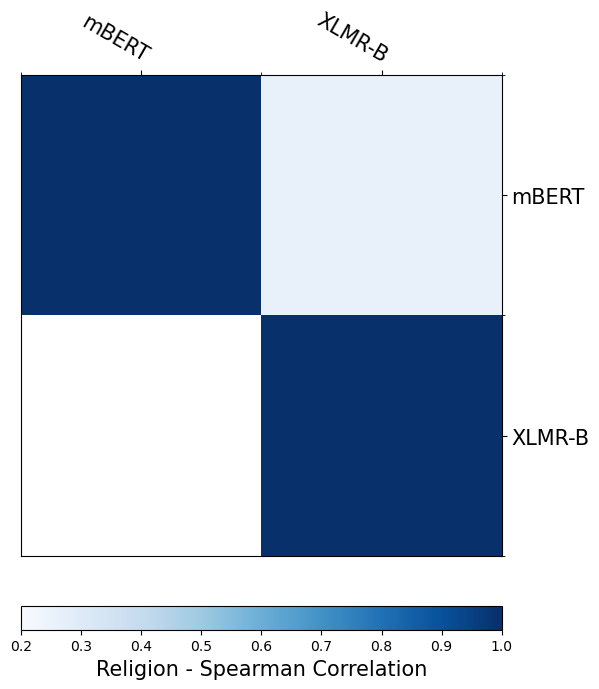

interactive(children=(Dropdown(description='Category', index=1, options=('age', 'religion'), value='religion')…

<function __main__.view_image(i)>

In [2]:
categories = widgets.Dropdown(
    options=['age', 'religion', 'political', 'race', 'gender', 'country', 'sexuality', 'lifestyle', 'profession'],
    value='religion',
    description='Category',
    disabled=False,
)


def view_image(i):
    test, im, cbar = comparison_across_models(i, 'fr', 'French (fr)')
    display()

interact(view_image, i=categories)
    


## PART 4: Stereotype and emotion shift after fine-tuning 

Visualization of the effect of fine-tuning a pretrained model on different news sources with respect to the emotion profiles within the models (as measured by RSA). Select the model and social category you want to study. 

In [13]:
categories = widgets.Dropdown(
    options=['age', 'religion', 'political', 'race', 'gender', 'country', 'sexuality', 'lifestyle', 'profession'],
    value='gender',
    description='Category',
    disabled=False,
)

models = widgets.Dropdown(
    options=['BERT-B', 'RoBERTa-B','BART-B', 'mBERT', 'XLMR-B'],
    value='BART-B',
    description='Model',
    disabled=False,
)


def view_image(i, model):
    im, cbar = comparison_within_models(i, model, 'finetuned1epoch')
    display()
interact(view_image, i=categories, model=models)


interactive(children=(Dropdown(description='Category', index=4, options=('age', 'religion', 'political', 'race…

<function __main__.view_image(i, model)>

These are the results after fine-tuning BERT-B on different proportions of the news data. Select whether you want to see the effect of the full dataset (finetuned1epoch), half, a quart or a tenth of the dataset. 

In [14]:
models = widgets.Dropdown(
    options=['BERT-B'],
    value='BERT-B',
    description='Model',
    disabled=False,
)

finetuned = widgets.Dropdown(
    options=['finetuned1epoch', 'finetuned-half','finetuned-quart', 'finetuned-tenth'],
    value='finetuned1epoch',
    description='Proportion of data',
    disabled=False,
)

def view_image(i, model, finetune):
    im, cbar = comparison_within_models(i, model, finetune)
    display()
interact(view_image, i=categories, model=models, finetune=finetuned)

interactive(children=(Dropdown(description='Category', index=4, options=('age', 'religion', 'political', 'race…

<function __main__.view_image(i, model, finetune)>

We now show the specific stereotypes that shifts as a result of fine-tuning on a news source. Removed attributes are indicated by red and those added by green. Attributes that persisted after fine-tuning are grey. Please specify the social group for which you want to generate the wordcloud plot and the news source on which the model was pretrained. 

In [15]:
news_source = widgets.Dropdown(
    options=['breitbart', 'fox','reuters', 'guardian', 'new_yorker'],
    value='guardian',
    description='Model',
    disabled=False,
)

txtsl_group = widgets.Text(placeholder='Enter words to get attributes for',font_size=1000,
                    description='Social groups', value='black people')


interact(get_shifts, interest=txtsl_group, source=news_source )

interactive(children=(Text(value='black people', description='Social groups', placeholder='Enter words to get …

<function utils.study_stereotypes.get_shifts(interest, source='reuters')>